In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'


### 동대문구 내 따릉이 대여소 정보

In [2]:
Bike_Stop = pd.read_excel('./raw data/대여소/서울특별시 공공자전거 대여소 정보(19.12.9).xlsx')
Bike_Stop_ID = Bike_Stop.groupby('대여소_구')['대여소ID'].unique().loc['동대문구']
#Bike_Stop_ID = np.append(Bike_Stop_ID, 664)
Bike_Stop_ID = Bike_Stop_ID.astype(np.int64)
Bike_Stop_ID

array([600, 601, 602, 604, 605, 606, 607, 608, 609, 610, 612, 613, 614,
       615, 616, 617, 621, 622, 623, 624, 625, 626, 627, 628, 630, 631,
       633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 646, 647,
       648, 650, 651, 652, 654, 656, 657, 658, 659, 660, 661, 663],
      dtype=int64)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
import xgboost as xgb
from scipy.stats import uniform, randint
import pickle
import os

In [4]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)'] + dayofweek
features

['월',
 '시간',
 '최저기온(°C)',
 '최고기온(°C)',
 '일강수량(mm)',
 '최대 풍속(m/s)',
 '평균 상대습도(%)',
 '요일_0',
 '요일_1',
 '요일_2',
 '요일_3',
 '요일_4',
 '요일_5',
 '요일_6']

### xgboost 모델 불러오기 (pkl)

#### Inflow

In [5]:
dirs_in = os.getcwd() + '/model/Inflow'
files_in = os.listdir(dirs_in)
#files_in

In [6]:
cols = ['월', '요일', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)']
Model_Inflow = {}

In [7]:
in_pkl_path = "./model/Inflow/inflow_"
for id_stop in Bike_Stop_ID:
    #pickle.dump(result['model'], open(in_pkl_path+str(id_stop)+".pkl", "wb"))
    Model_Inflow[str(id_stop)] = pickle.load(open(in_pkl_path+str(id_stop)+".pkl", "rb"))

In [8]:
Model_Inflow

{'600': XGBRegressor(gamma=0.2622305330429327, max_depth=2, missing=nan,
              n_estimators=137, objective='reg:squarederror'),
 '601': XGBRegressor(gamma=0.22362503235822068, max_depth=2, missing=nan,
              n_estimators=117, objective='reg:squarederror'),
 '602': XGBRegressor(gamma=0.24389735591831602, max_depth=6, missing=nan,
              n_estimators=104, objective='reg:squarederror'),
 '604': XGBRegressor(gamma=0.4092145974043811, missing=nan, n_estimators=104,
              objective='reg:squarederror'),
 '605': XGBRegressor(gamma=0.19748386918597843, max_depth=4, missing=nan,
              n_estimators=107, objective='reg:squarederror'),
 '606': XGBRegressor(gamma=0.07859802626682111, missing=nan, n_estimators=103,
              objective='reg:squarederror'),
 '607': XGBRegressor(gamma=0.03182577657327057, max_depth=2, missing=nan,
              n_estimators=128, objective='reg:squarederror'),
 '608': XGBRegressor(gamma=0.042809418022575596, max_depth=2, missing

#### Outflow

In [9]:
dirs_out = os.getcwd() + '/model/Outflow'
files_out = os.listdir(dirs_out)
#files_out

In [10]:
Model_Outflow = {}

In [11]:
out_pkl_path = "./model/Outflow/outflow_"
for id_stop in Bike_Stop_ID:
    #pickle.dump(result['model'], open(in_pkl_path+str(id_stop)+".pkl", "wb"))
    Model_Outflow[str(id_stop)] = pickle.load(open(out_pkl_path+str(id_stop)+".pkl", "rb"))

In [12]:
Model_Outflow

{'600': XGBRegressor(gamma=0.21669064474598965, max_depth=2, missing=nan,
              n_estimators=102, objective='reg:squarederror'),
 '601': XGBRegressor(gamma=0.3438757606880997, missing=nan, n_estimators=111,
              objective='reg:squarederror'),
 '602': XGBRegressor(gamma=0.18529267470936117, max_depth=5, missing=nan,
              n_estimators=106, objective='reg:squarederror'),
 '604': XGBRegressor(gamma=0.07797812384781022, max_depth=4, missing=nan,
              n_estimators=141, objective='reg:squarederror'),
 '605': XGBRegressor(gamma=0.2203956925273235, missing=nan, n_estimators=112,
              objective='reg:squarederror'),
 '606': XGBRegressor(gamma=0.43394317451086717, missing=nan, n_estimators=118,
              objective='reg:squarederror'),
 '607': XGBRegressor(gamma=0.3155992290700645, missing=nan, n_estimators=106,
              objective='reg:squarederror'),
 '608': XGBRegressor(gamma=0.4202764527513919, max_depth=2, missing=nan,
              n_estimat

## API 이용하여 input parameter 만들기

### 공공데이터포털 기상청 API

In [13]:
import requests
import json
import datetime

In [14]:
vilage_weather_url = "http://apis.data.go.kr/1360000/VilageFcstInfoService/getVilageFcst?"

service_key = "33CwubzPkYtsaIF%2FC%2FcXBRHrNKfD2GczNC79ddAsLSmi7S7ZVvdt7A%2FzQWJQgbiSD5gu85leQwxOOgRjV%2BAgaA%3D%3D"

today = datetime.datetime.today()
base_date = today.strftime("%Y%m%d") 
base_time = "0500" # 전날의 05시 이후에 동작해야 함

nx = "61"
ny = "127" # 동대문구의 좌표

payload1 = "serviceKey=" + service_key + "&" +\
    "numOfRows=50&" +\
    "pageNo=2&" +\
    "dataType=json" + "&" +\
    "base_date=" + base_date + "&" +\
    "base_time=" + base_time + "&" +\
    "nx=" + nx + "&" +\
    "ny=" + ny

# 값 요청
res1 = requests.get(vilage_weather_url + payload1)

#items1 = res1.json().get('response').get('body').get('items')
data1 = res1.json()
items1 = pd.DataFrame(data1['response']['body']['items']['item'])

In [15]:
#items1

In [16]:
payload2 = "serviceKey=" + service_key + "&" +\
    "numOfRows=50&" +\
    "pageNo=3&" +\
    "dataType=json" + "&" +\
    "base_date=" + base_date + "&" +\
    "base_time=" + base_time + "&" +\
    "nx=" + nx + "&" +\
    "ny=" + ny

# 값 요청
res2 = requests.get(vilage_weather_url + payload2)

#items2 = res2.json().get('response').get('body').get('items')
data2 = res2.json()
items2 = pd.DataFrame(data2['response']['body']['items']['item'])

In [17]:
#items2

In [18]:
idx = list(range(32, 50))
items2 = items2.drop(idx)
items = pd.concat([items1, items2]).reset_index(drop=True).copy()
items

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny
0,20201123,0500,POP,20201124,0000,0,61,127
1,20201123,0500,PTY,20201124,0000,0,61,127
2,20201123,0500,R06,20201124,0000,0,61,127
3,20201123,0500,REH,20201124,0000,65,61,127
4,20201123,0500,S06,20201124,0000,0,61,127
...,...,...,...,...,...,...,...,...
77,20201123,0500,T3H,20201124,2100,4,61,127
78,20201123,0500,UUU,20201124,2100,0.2,61,127
79,20201123,0500,VEC,20201124,2100,349,61,127
80,20201123,0500,VVV,20201124,2100,-1,61,127


In [19]:
items = items.astype({'fcstValue': np.float})
items.dtypes

baseDate      object
baseTime      object
category      object
fcstDate      object
fcstTime      object
fcstValue    float64
nx             int64
ny             int64
dtype: object

In [20]:
# 최저기온 (0600에만 예보됨)
min_temp = float(items[items['category'] == 'TMN']['fcstValue'])
min_temp

0.0

In [21]:
# 최고기온 (1500에만 예보됨)
max_temp = float(items[items['category'] == 'TMX']['fcstValue'])
max_temp

8.0

In [22]:
# 일 강수량 (0000, 0600, 1200, 1800의 값들 모두 더하기)
r06 = items[items['category'] == 'R06']
rain_fall = float(r06['fcstValue'].sum())
rain_fall

0.0

In [23]:
# 풍속 (최댓값 구하기)
wsd = items[items['category'] == 'WSD']
wind_speed = float(wsd['fcstValue'].max())
wind_speed

1.4

In [24]:
# 습도 (평균 구하기)
reh = items[items['category'] == 'REH']
humidity = float(reh['fcstValue'].mean())
humidity

60.625

### Input parameter list 만들기
- 월, 시간, 최저기온, 최고기온, 일강수량, 풍속, 습도, 요일

In [25]:
from datetime import date, timedelta

In [26]:
# 내일 날짜 불러오기
tomorrow = date.today() + timedelta(1)
tomorrow

datetime.date(2020, 11, 24)

In [27]:
# 월
tomorrow.month

11

In [28]:
# 요일
weekday = [0, 0, 0, 0, 0, 0, 0]
weekday[tomorrow.weekday()] = 1
weekday

[0, 1, 0, 0, 0, 0, 0]

In [52]:
# 시간
time_slot = list(range(5, 22))
time_slot

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

### param

In [30]:
param = []

In [31]:
param += [tomorrow.month, 0, min_temp, max_temp, rain_fall, wind_speed, humidity]
param

[11, 0, 0.0, 8.0, 0.0, 1.4, 60.625]

In [32]:
param += weekday
param

[11, 0, 0.0, 8.0, 0.0, 1.4, 60.625, 0, 1, 0, 0, 0, 0, 0]

In [33]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)'] + dayofweek
features

['월',
 '시간',
 '최저기온(°C)',
 '최고기온(°C)',
 '일강수량(mm)',
 '최대 풍속(m/s)',
 '평균 상대습도(%)',
 '요일_0',
 '요일_1',
 '요일_2',
 '요일_3',
 '요일_4',
 '요일_5',
 '요일_6']

In [34]:
params = []
for i in time_slot:
    tmpp = param.copy()
    tmpp[1] = i
    #print(tmpp)
    params.append(tmpp)
    
params = np.array(params)
params

array([[11.   ,  5.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [11.   ,  6.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [11.   ,  7.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [11.   ,  8.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [11.   ,  9.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [11.   , 10.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [11.   , 11.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [11.   , 12.   ,  0.   ,  8.   ,  0.   ,  1.4  , 60.625,  0.   ,
         1.   ,  0.   ,  

### for test (602)

In [37]:
input_params = pd.DataFrame(params, columns = features)
Model_Inflow['602'].predict(input_params)

array([1.1260947, 1.2394036, 1.8911349, 4.279166 , 3.2085555, 2.8415422,
       2.704487 , 3.6108685, 3.9698322, 3.4715443, 3.6331365, 3.6776443,
       3.9741886, 7.926815 , 9.740038 , 5.3856506, 3.8917367],
      dtype=float32)

In [38]:
Model_Outflow['602'].predict(input_params)

array([1.3311841, 1.4257427, 2.111462 , 5.9463735, 2.726058 , 2.6899233,
       2.6134515, 2.9707122, 3.2854514, 3.4614534, 3.2922692, 3.5488493,
       3.667566 , 4.70074  , 4.045473 , 4.9687657, 4.8107533],
      dtype=float32)

## Result_Inflow, Result_Outflow 만들기

In [47]:
Result_Inflow = {}
for stop_id in Bike_Stop_ID:
    Result_Inflow[str(stop_id)] = {}
    for time in time_slot:
        Result_Inflow[str(stop_id)][str(time)] = Model_Inflow[str(stop_id)].predict(input_params)[time-5]

    
#Result_Inflow

### alpha = 0.85로 가정

In [153]:
alpha = 0.85

In [154]:
Result_All = {}
for stop_id in Bike_Stop_ID:
    Result_All[str(stop_id)] = {}
    for time in time_slot:
        inflow = Model_Inflow[str(stop_id)].predict(input_params)
        outflow = Model_Outflow[str(stop_id)].predict(input_params)
        delta = alpha * (inflow - outflow) + (1 - alpha) * inflow
        Result_All[str(stop_id)]['대여소ID'] = stop_id
        Result_All[str(stop_id)]['Time Slot'] = time_slot
        Result_All[str(stop_id)]['Inflow'] = inflow
        Result_All[str(stop_id)]['Outflow'] = outflow
        Result_All[str(stop_id)]['Delta'] = delta
        
Result_All

{'600': {'대여소ID': 600,
  'Time Slot': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  'Inflow': array([0.9992367, 0.9992367, 1.0734487, 1.0734487, 1.0734487, 1.0734487,
         1.0734487, 1.0734487, 1.0734487, 1.0866717, 1.0866717, 1.0866717,
         1.0866717, 1.1175747, 1.1175747, 1.1175747, 1.1175747],
        dtype=float32),
  'Outflow': array([1.3456765, 1.3456765, 1.3456765, 1.4228996, 1.4228996, 1.4228996,
         1.4228996, 1.4228996, 1.4228996, 1.5390213, 1.5323758, 1.6257646,
         1.6257646, 1.6257646, 1.5707194, 1.5707194, 1.5707194],
        dtype=float32),
  'Delta': array([-0.14458835, -0.14458835, -0.07037641, -0.13601601, -0.13601601,
         -0.13601601, -0.13601601, -0.13601601, -0.13601601, -0.22149637,
         -0.21584773, -0.2952282 , -0.2952282 , -0.26432523, -0.21753678,
         -0.21753678, -0.21753678], dtype=float32)},
 '601': {'대여소ID': 601,
  'Time Slot': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  'Inflow':

In [155]:
pd.DataFrame(Result_All['602'])

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,602,5,1.126095,1.331184,-0.005412
1,602,6,1.239404,1.425743,0.027522
2,602,7,1.891135,2.111462,0.096392
3,602,8,4.279166,5.946373,-0.775251
4,602,9,3.208555,2.726058,0.891406
5,602,10,2.841542,2.689923,0.555107
6,602,11,2.704487,2.613451,0.483053
7,602,12,3.610868,2.970712,1.085763
8,602,13,3.969832,3.285451,1.177199
9,602,14,3.471544,3.461453,0.529309


In [156]:
pd.DataFrame(Result_All['634'])

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,634,5,1.578109,1.428279,0.364073
1,634,6,1.584434,1.394763,0.398886
2,634,7,2.232976,1.985972,0.544900
3,634,8,3.925894,2.719592,1.614241
4,634,9,2.406382,2.692432,0.117814
5,634,10,2.673750,2.692432,0.385183
6,634,11,2.673750,2.956466,0.160754
7,634,12,2.575631,2.748410,0.239483
8,634,13,2.483923,2.730739,0.162795
9,634,14,2.675592,3.004440,0.121818


### 모든 대여소의 예측 값을 하나의 dataframe으로 합치기

In [157]:
Result = pd.DataFrame(Result_All['600'])
for id_stop in Bike_Stop_ID:
    if id_stop == 600:
        continue
    tmppp = pd.DataFrame(Result_All[str(id_stop)])
    Result = pd.concat([Result, tmppp])
    
Result = Result.reset_index(drop = True)
Result

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,600,5,0.999237,1.345677,-0.144588
1,600,6,0.999237,1.345677,-0.144588
2,600,7,1.073449,1.345677,-0.070376
3,600,8,1.073449,1.422900,-0.136016
4,600,9,1.073449,1.422900,-0.136016
...,...,...,...,...,...
862,663,17,2.886145,2.977788,0.355025
863,663,18,3.367977,3.034288,0.788832
864,663,19,2.920244,2.992836,0.376333
865,663,20,3.370849,2.462992,1.277307


### heatmap

In [158]:
Bike_Map = Result.pivot('대여소ID', 'Time Slot', 'Delta')

In [159]:
Bike_Map

Time Slot,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
대여소ID,,,,,,,,,,,,,,,,,
600,-0.144588,-0.144588,-0.070376,-0.136016,-0.136016,-0.136016,-0.136016,-0.136016,-0.136016,-0.221496,-0.215848,-0.295228,-0.295228,-0.264325,-0.217537,-0.217537,-0.217537
601,0.392927,0.392927,0.464854,0.954677,0.524543,0.418875,0.418875,0.439888,0.448887,0.626806,0.920739,0.761013,0.394401,-0.039932,0.678147,0.778053,0.807881
602,-0.005412,0.027522,0.096392,-0.775251,0.891406,0.555107,0.483053,1.085763,1.177199,0.529309,0.834708,0.661122,0.856757,3.931186,6.301386,1.162200,-0.197404
604,0.807919,0.807919,-0.099272,-5.165228,-0.625778,-0.006621,-0.070736,-0.024266,0.051954,0.307638,0.310504,0.598252,0.765615,1.850431,1.356484,1.613518,1.771567
605,0.186028,0.186028,0.421662,2.687903,0.864080,-0.367590,-0.367590,-0.166652,-0.201244,-0.185973,-0.185973,-0.154534,-0.269860,-0.180520,0.374918,0.197828,0.631669
606,1.365267,1.365267,1.450695,2.523216,0.477112,0.404533,0.353630,-0.057085,-0.052013,-0.455891,-0.187341,-2.043375,0.760239,1.885727,1.863414,0.411725,0.094297
607,0.094366,0.158573,-0.450817,-1.691667,-0.213238,-0.167464,-0.167464,-0.171563,-0.171563,-0.131098,-0.141878,0.240890,0.296783,0.863050,0.208245,0.776137,0.924026
608,0.231854,0.231854,0.231854,0.435538,0.205389,0.197620,0.174416,0.174416,0.168692,0.168692,0.168692,0.168692,0.210325,0.210325,0.207626,0.207626,0.097669
609,0.710659,0.875782,0.520613,-3.897087,0.243370,-0.111727,0.075197,0.316595,0.446019,0.455988,0.730073,0.914407,0.136095,2.203032,0.784429,0.820402,1.630334


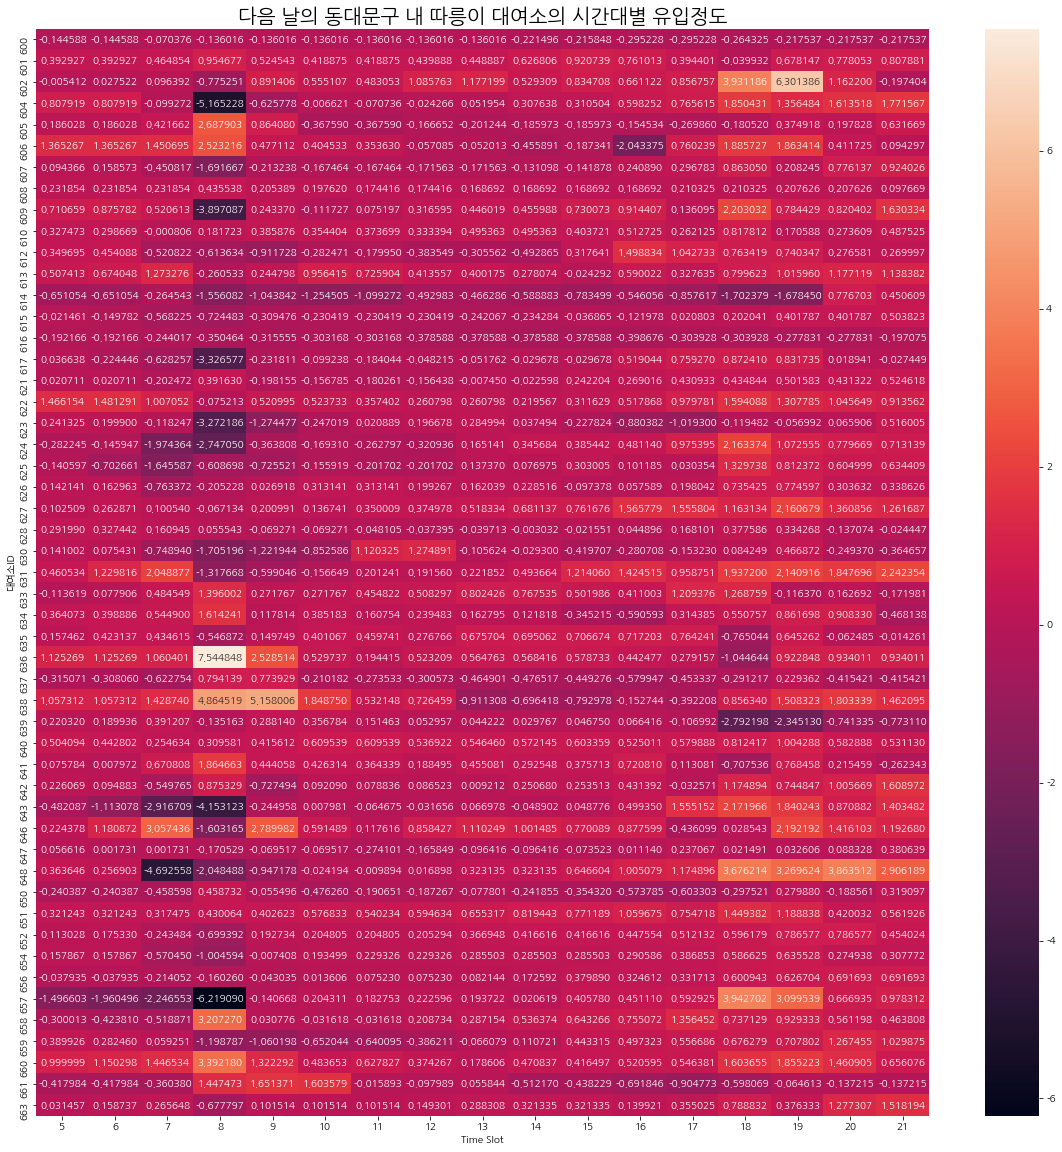

In [160]:
#Bike_Map.fillna(value=np.nan, inplace=True)
plt.figure(figsize=(20,20))
sns.heatmap(Bike_Map, annot=True, fmt=".6f")
plt.title('다음 날의 동대문구 내 따릉이 대여소의 시간대별 유입정도', fontsize=20)
plt.show()